In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix, classification_report
from lightgbm import LGBMClassifier

%config InlineBackend.figure_format = 'retina'

In [3]:
scada_df = pd.read_csv('C:/Users/purva/OneDrive/Desktop/Project/Breakdown SCADA/scada_data.csv')
scada_df['DateTime'] = pd.to_datetime(scada_df['DateTime'])
# scada_df.set_index('DateTime', inplace=True)

scada_df

,DateTime,Time,Error,WEC: ava. windspeed,WEC: max. windspeed,WEC: min. windspeed,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,...,Rectifier cabinet temp.,Yaw inverter cabinet temp.,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev
0,2014-05-01 00:00:00,1398920448,0,6.9,9.4,2.9,0.00,0.02,0.00,0,...,24,20,25,12,14,24,34,2501,25.272728,1.103713
1,2014-05-01 00:09:00,1398920960,0,5.3,8.9,1.6,0.00,0.01,0.00,0,...,24,20,25,12,14,24,34,2501,25.272728,1.103713
2,2014-05-01 00:20:00,1398921600,0,5.0,9.5,1.4,0.00,0.04,0.00,0,...,24,20,25,12,14,24,34,2501,25.272728,1.103713
3,2014-05-01 00:30:00,1398922240,0,4.4,8.3,1.3,0.00,0.08,0.00,0,...,23,21,25,12,14,24,34,2501,25.272728,1.103713
4,2014-05-01 00:39:00,1398922752,0,5.7,9.7,1.2,0.00,0.05,0.00,0,...,23,21,25,12,14,23,34,2501,25.272728,1.103713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49022,2015-04-08 23:20:00,1428553216,0,3.9,5.5,2.2,6.75,7.40,6.01,147,...,33,23,28,9,17,27,35,3050,24.454546,3.474583
49023,2015-04-08 23:30:00,1428553856,0,3.9,5.6,2.9,6.64,7.06,6.33,128,...,34,23,28,9,17,27,35,3050,24.454546,3.445683
49024,2015-04-08 23:39:00,1428554368,0,4.2,6.7,2.6,7.18,8.83,6.22,163,...,34,23,28,9,18,27,34,3050,24.363636,3.413876
49025,2015-04-08 23:50:00,1428555008,0,4.1,6.6,2.7,7.02,7.94,6.20,160,...,33,23,28,9,17,27,34,3050,24.000000,3.376389


In [25]:
status_df = pd.read_csv('C:/Users/purva/OneDrive/Desktop/Project/Breakdown SCADA/status_data.csv')
status_df['Time'] = pd.to_datetime(status_df['Time'])
status_df.rename(columns={'Time': 'DateTime'}, inplace=True)
# status_df.set_index('DateTime', inplace=True)

status_df

,DateTime,Main Status,Sub Status,Full Status,Status Text,T,Service,FaultMsg,Value0
0,2014-04-24 12:37:00,0,0,00:00,Turbine in operation,1,False,False,7.400
1,2014-04-25 19:27:00,71,104,71 : 104,Insulation monitoring : Insulation fault Phase U2,6,False,True,20.500
2,2014-04-26 09:30:00,8,0,08:00,Maintenance,6,True,False,17.100
3,2014-04-26 10:05:00,8,0,08:00,Maintenance,6,False,False,8.700
4,2014-04-26 10:05:00,8,0,08:00,Maintenance,6,True,False,10.600
...,...,...,...,...,...,...,...,...,...
1844,2015-04-27 07:26:00,0,0,00:00,Turbine in operation,1,False,False,7.000
1845,2015-04-28 22:14:00,26,373,26 : 373,Malfunction fan-inverter : Other control board...,6,False,False,8.100
1846,2015-04-28 22:14:00,0,2,00:02,Turbine operational,1,False,False,9.500
1847,2015-04-28 22:17:00,0,1,00:01,Turbine starting,1,False,False,11.100


In [26]:
fault_df = pd.read_csv('C:/Users/purva/OneDrive/Desktop/Project/Breakdown SCADA/fault_data.csv')
fault_df['DateTime'] = pd.to_datetime(fault_df['DateTime'])
# fault_df.set_index('DateTime', inplace=True)

fault_df

,DateTime,Time,Fault
0,2014-05-14 14:39:00,1400096384,GF
1,2014-05-14 14:50:00,1400097024,GF
2,2014-05-14 14:58:00,1400097536,GF
3,2014-05-14 15:09:00,1400098176,GF
4,2014-05-14 15:20:00,1400098816,GF
...,...,...,...
548,2015-01-14 23:00:00,1421298048,AF
549,2015-01-14 23:09:00,1421298560,AF
550,2015-01-15 22:50:00,1421383808,AF
551,2015-01-15 23:00:00,1421384448,AF


In [27]:
fault_df.Fault.unique()

array(['GF', 'MF', 'FF', 'AF', 'EF'], dtype=object)

(0.0, 4.0)

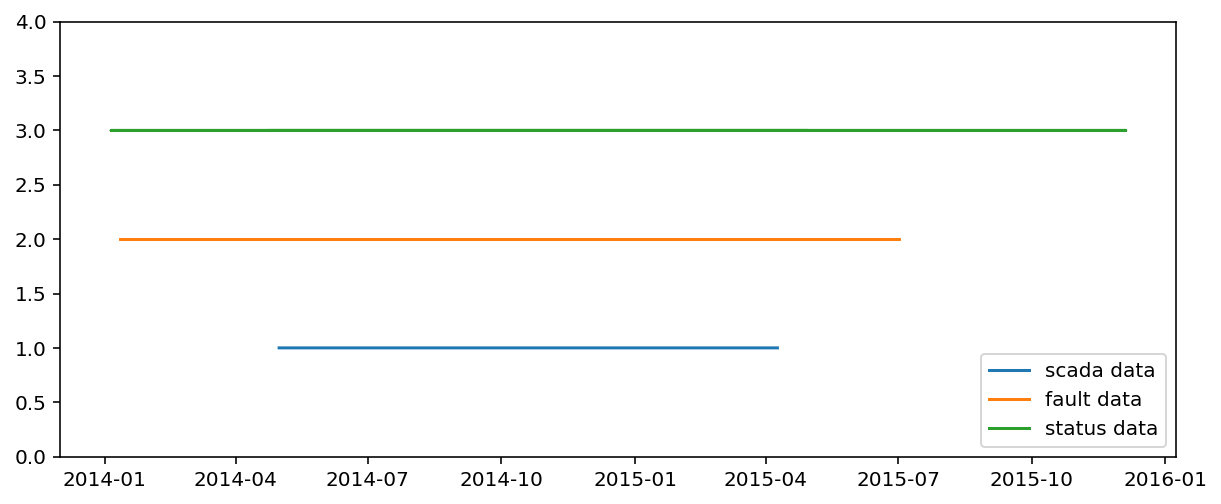

In [28]:
# Plot time span of all data
t_scada = scada_df.DateTime
t_fault = fault_df.DateTime
t_status = status_df.DateTime

plt.figure(figsize=(10,4))
plt.plot(t_scada, np.full(len(scada_df), 1), label='scada data')
plt.plot(t_fault, np.full(len(fault_df), 2), label='fault data')
plt.plot(t_status, np.full(len(status_df), 3), label='status data')
plt.legend(loc='lower right')
plt.ylim(0,4)

<AxesSubplot:xlabel='DateTime'>

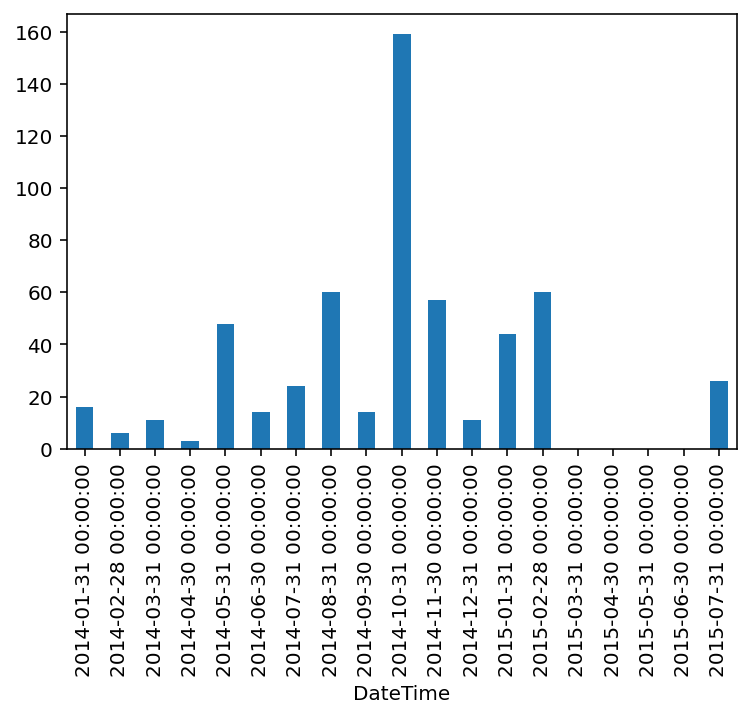

In [29]:
# Plot of number of faults on monthly resampled data
fault_df.resample('M', on='DateTime').Fault.count().plot.bar()

In [30]:
fault_df.resample('M', on='DateTime').Fault.value_counts()

DateTime    Fault
2014-01-31  EF        9
            FF        7
2014-02-28  EF        3
            FF        3
2014-03-31  EF        4
            AF        3
            FF        2
            MF        2
2014-04-30  MF        3
2014-05-31  FF       31
            EF       10
            GF        6
            MF        1
2014-06-30  FF        5
            EF        4
            AF        3
            MF        2
2014-07-31  AF       10
            EF        8
            FF        6
2014-08-31  AF       26
            FF       25
            EF        5
            MF        4
2014-09-30  AF        6
            FF        6
            MF        2
2014-10-31  EF       82
            FF       61
            GF       11
            AF        3
            MF        2
2014-11-30  EF       42
            FF       10
            AF        3
            MF        2
2014-12-31  EF        7
            AF        2
            MF        2
2015-01-31  FF       38
            AF        

<AxesSubplot:title={'center':'Wind Turbine Faults'}, xlabel='DateTime', ylabel='Fault Counts'>

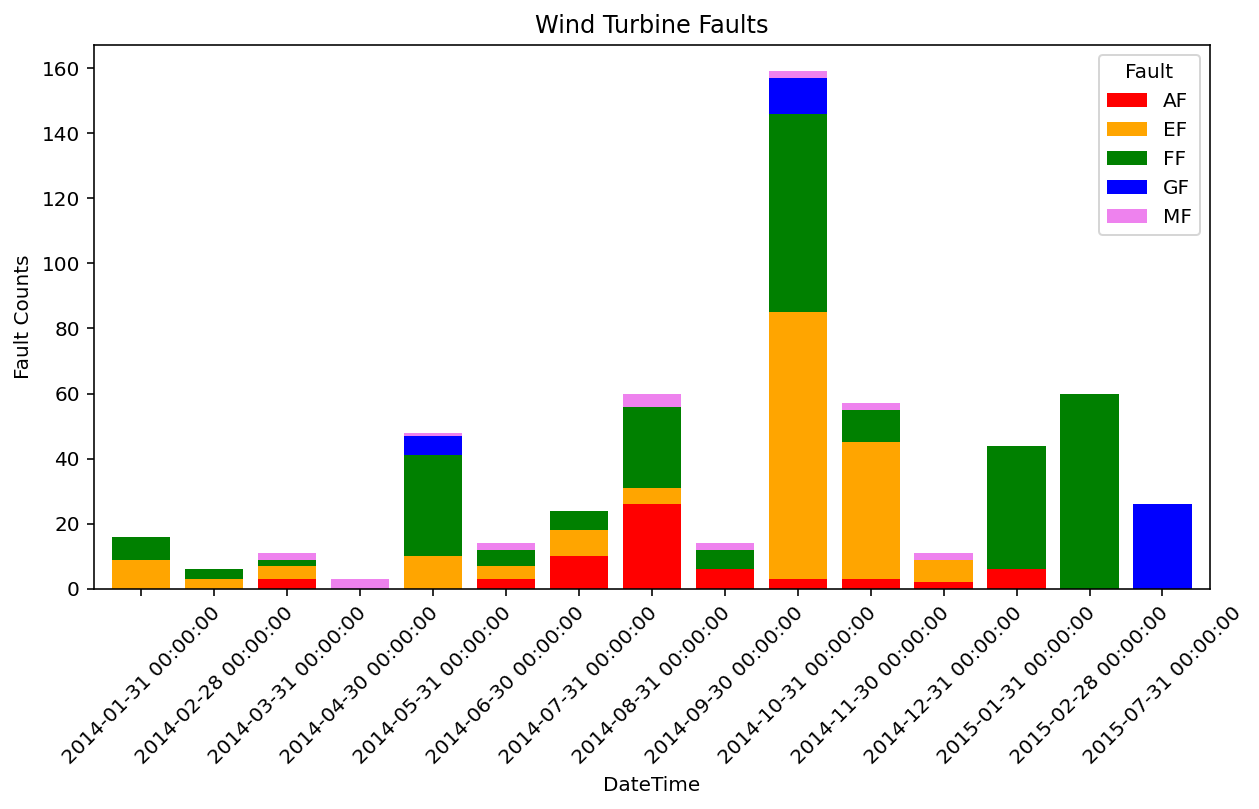

In [31]:
c = ['red', 'orange', 'green', 'blue', 'violet']
fault_df.resample('M', on='DateTime').Fault.value_counts().unstack().plot.bar(stacked=True, width=0.8, figsize=(10,5), color=c, rot=45,
                                                                              title='Wind Turbine Faults', ylabel='Fault Counts')


<AxesSubplot:>

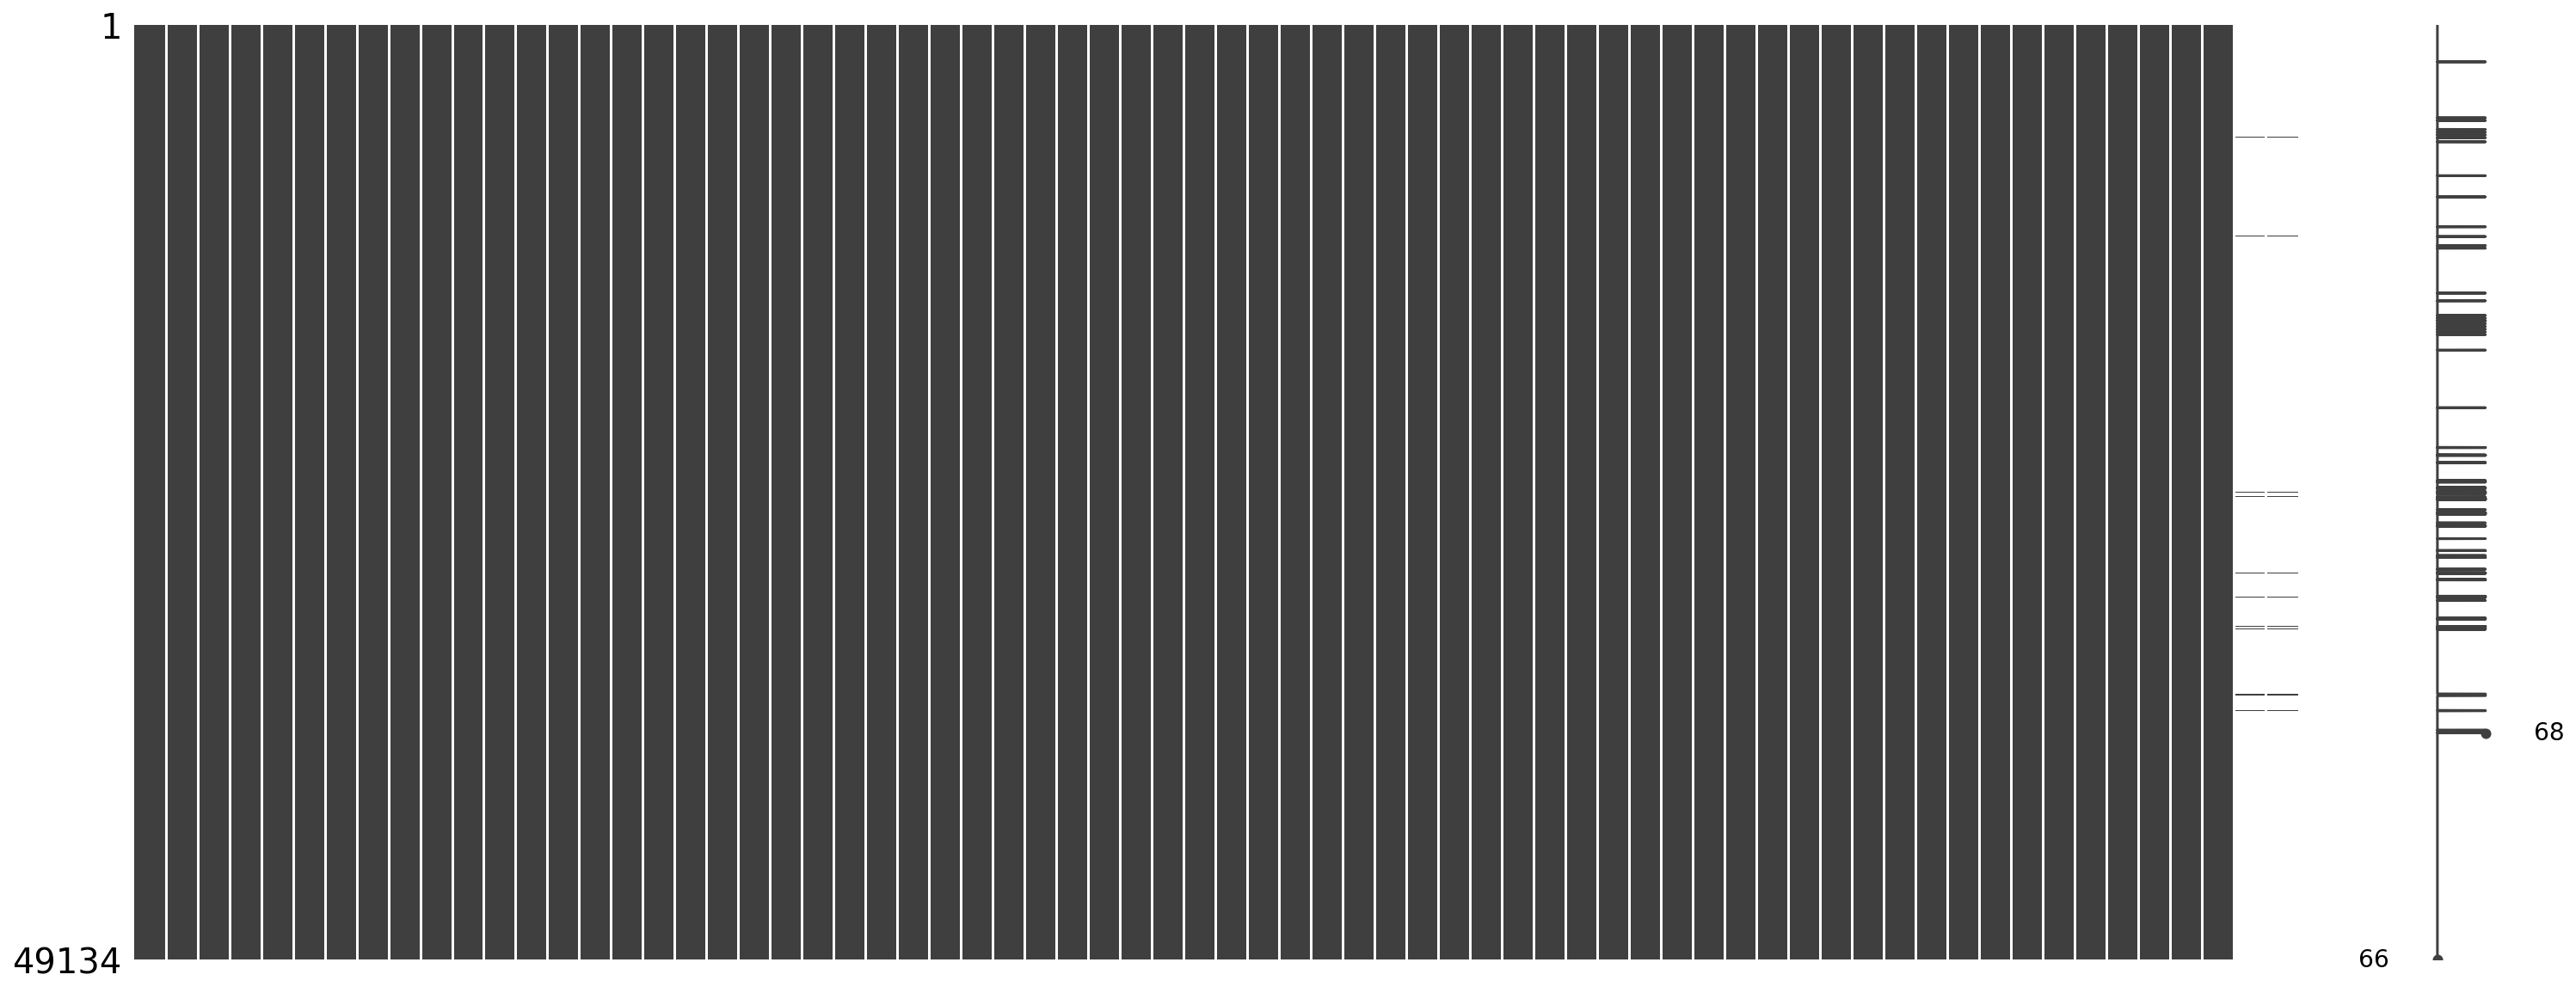

In [32]:
# Combine scada and fault data
df_combine = scada_df.merge(fault_df, on='Time', how='outer')
msno.matrix(df_combine)

In [33]:
# Replace records that has no fault label (NaN) as 'NF' (no fault)
df_combine['Fault'] = df_combine['Fault'].replace(np.nan, 'NF')

df_combine

,DateTime_x,Time,Error,WEC: ava. windspeed,WEC: max. windspeed,WEC: min. windspeed,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,...,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev,DateTime_y,Fault
0,2014-05-01 00:00:00,1398920448,0,6.900,9.400,2.900,0.000,0.020,0.000,0,...,25,12,14,24,34,2501,25.273,1.104,NaT,NF
1,2014-05-01 00:09:00,1398920960,0,5.300,8.900,1.600,0.000,0.010,0.000,0,...,25,12,14,24,34,2501,25.273,1.104,NaT,NF
2,2014-05-01 00:20:00,1398921600,0,5.000,9.500,1.400,0.000,0.040,0.000,0,...,25,12,14,24,34,2501,25.273,1.104,NaT,NF
3,2014-05-01 00:30:00,1398922240,0,4.400,8.300,1.300,0.000,0.080,0.000,0,...,25,12,14,24,34,2501,25.273,1.104,NaT,NF
4,2014-05-01 00:39:00,1398922752,0,5.700,9.700,1.200,0.000,0.050,0.000,0,...,25,12,14,23,34,2501,25.273,1.104,NaT,NF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49129,2015-04-08 23:20:00,1428553216,0,3.900,5.500,2.200,6.750,7.400,6.010,147,...,28,9,17,27,35,3050,24.455,3.475,NaT,NF
49130,2015-04-08 23:30:00,1428553856,0,3.900,5.600,2.900,6.640,7.060,6.330,128,...,28,9,17,27,35,3050,24.455,3.446,NaT,NF
49131,2015-04-08 23:39:00,1428554368,0,4.200,6.700,2.600,7.180,8.830,6.220,163,...,28,9,18,27,34,3050,24.364,3.414,NaT,NF
49132,2015-04-08 23:50:00,1428555008,0,4.100,6.600,2.700,7.020,7.940,6.200,160,...,28,9,17,27,34,3050,24.000,3.376,NaT,NF


In [34]:
# Suppress scientific notations
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Groupby fault and take average
df_summary = df_combine.groupby('Fault').mean().T
#T means transposing
df_summary.tail(60)

Fault,AF,EF,FF,GF,MF,NF
WEC: ava. Rotation,7.382,12.074,7.486,9.068,7.263,8.681
WEC: max. Rotation,10.974,15.078,9.624,10.235,11.470,9.535
WEC: min. Rotation,6.002,7.230,4.624,7.579,5.489,8.543
WEC: ava. Power,803.710,2428.069,1207.335,0.000,760.700,939.565
WEC: max. Power,1476.919,3128.213,1698.283,0.000,1536.050,1209.064
WEC: min. Power,491.919,1220.799,581.394,0.000,401.150,652.085
WEC: ava. Nacel position including cable twisting,-92.823,23.040,152.071,-2.116,112.950,25.281
WEC: Operating Hours,2782.097,4294.103,5005.992,4774.767,1997.250,4211.414
WEC: Production kWh,2415717.661,3704211.897,4636802.343,4569534.558,1751569.950,4021757.906
WEC: Production minutes,30.548,28.931,39.504,13.558,34.800,28.782


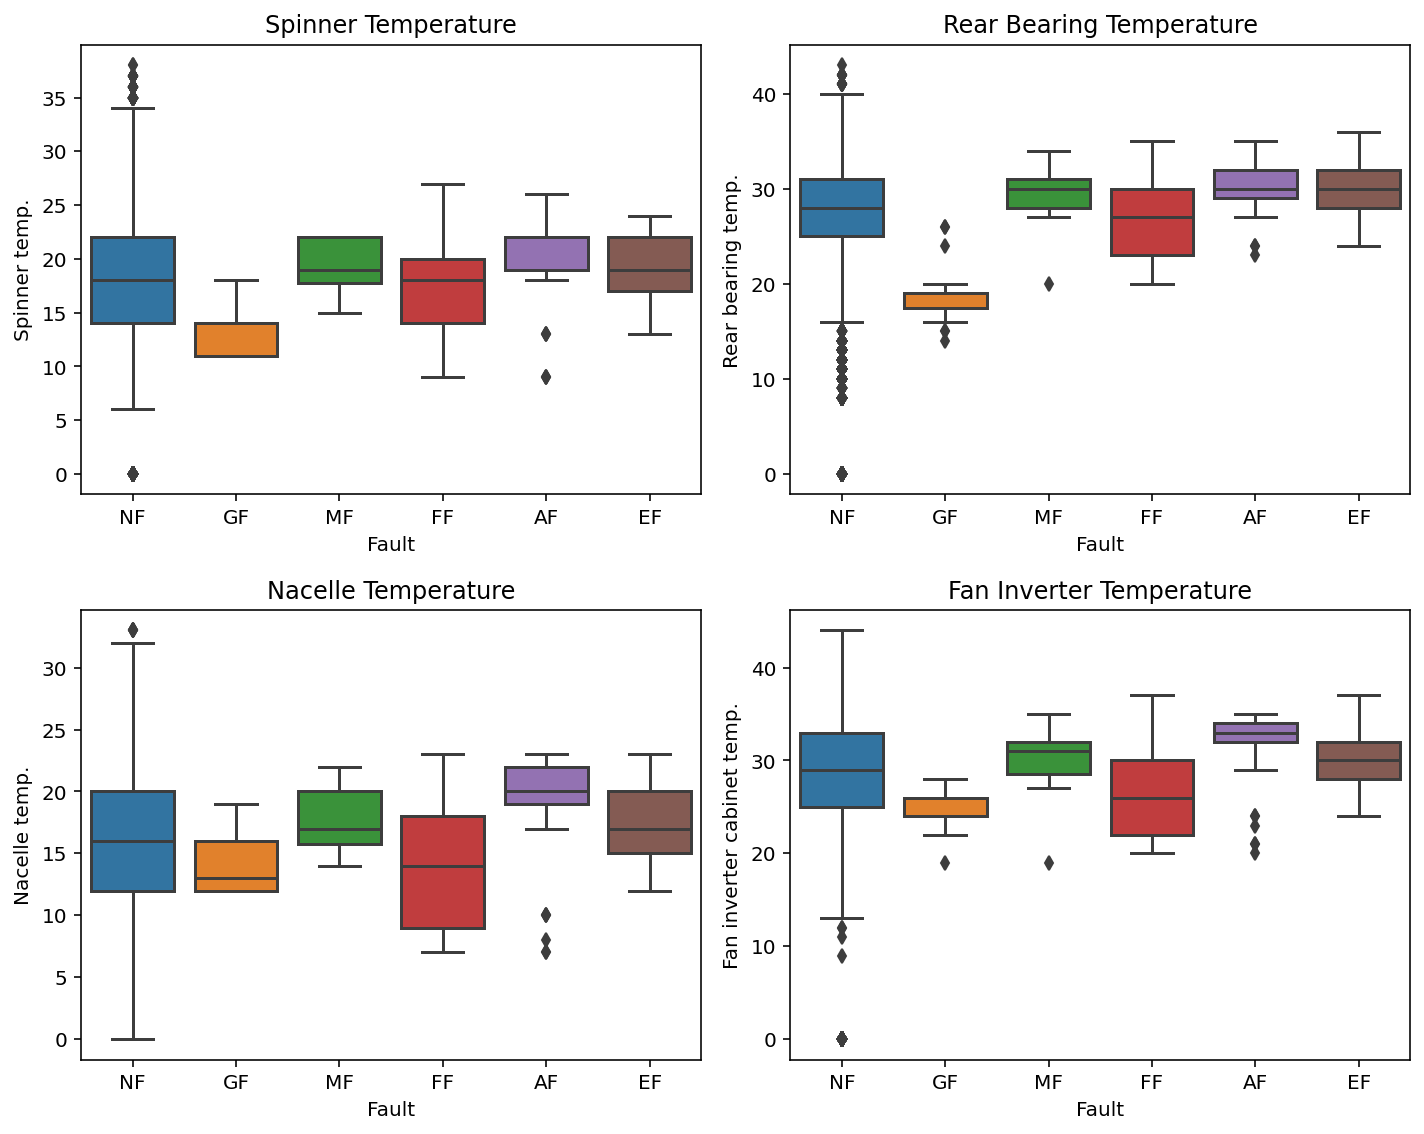

In [35]:
# Boxplots of temperature
f, axes = plt.subplots(nrows=2, ncols=2,figsize=(10,8))

sns.boxplot(x='Fault', y='Spinner temp.', data=df_combine, ax=axes[0][0])
axes[0][0].set_title('Spinner Temperature')
sns.boxplot(x='Fault', y='Rear bearing temp.', data=df_combine, ax=axes[0][1])
axes[0][1].set_title('Rear Bearing Temperature')
sns.boxplot(x='Fault', y='Nacelle temp.', data=df_combine, ax=axes[1][0])
axes[1][0].set_title('Nacelle Temperature')
sns.boxplot(x='Fault', y='Fan inverter cabinet temp.', data=df_combine, ax=axes[1][1])
axes[1][1].set_title('Fan Inverter Temperature')

plt.tight_layout()

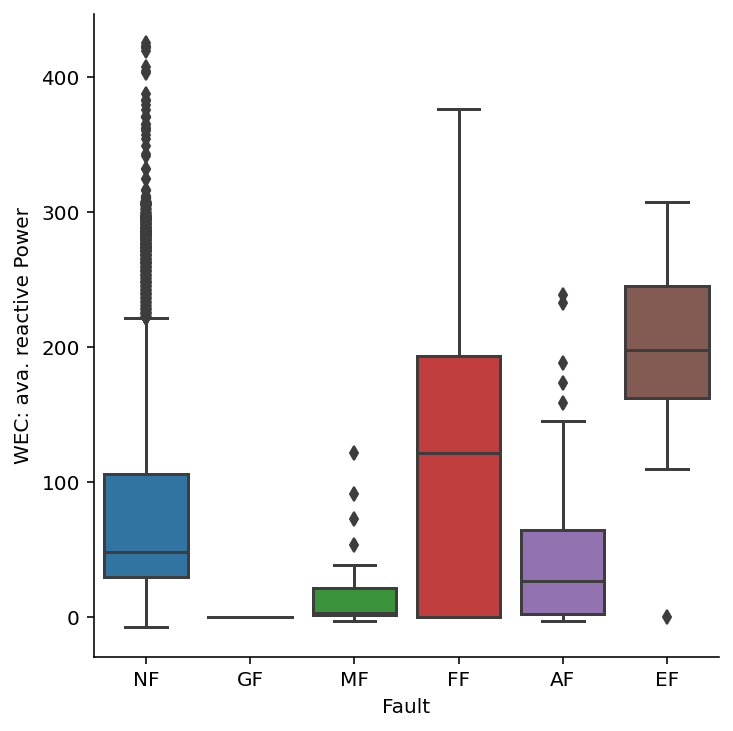

In [36]:
sns.catplot(data=df_combine, x='Fault', y='WEC: ava. reactive Power', kind='box')

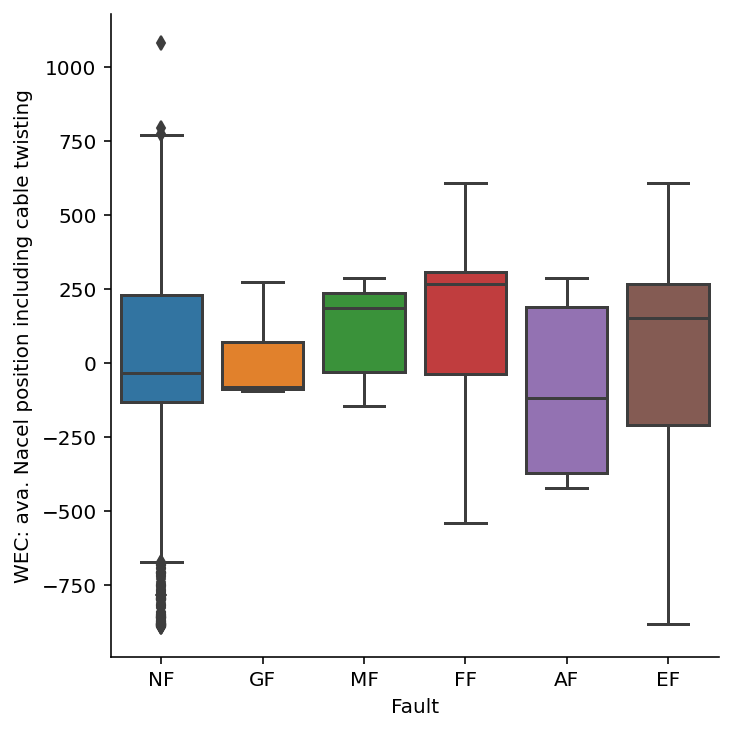

In [37]:
sns.catplot(data=df_combine, x='Fault', y='WEC: ava. Nacel position including cable twisting', kind='box')

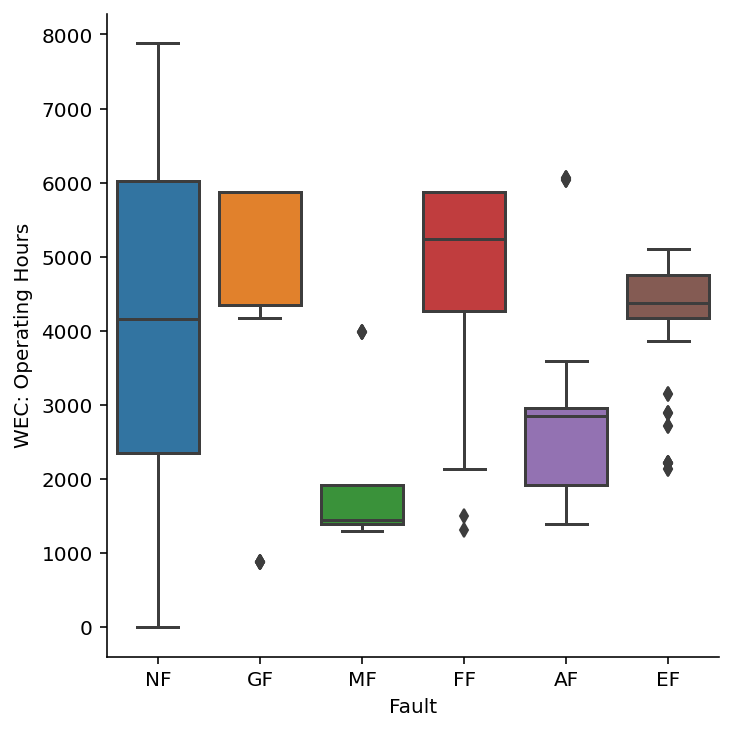

In [38]:
sns.catplot(data=df_combine, x='Fault', y='WEC: Operating Hours', kind='box')

In [39]:
df_combine.Fault.value_counts()

NF    48581
FF      254
EF      174
AF       62
GF       43
MF       20
Name: Fault, dtype: int64

In [40]:
# Pick 300 samples of NF (No Fault) mode data
df_nf = df_combine[df_combine.Fault=='NF'].sample(300, random_state=42)

df_nf

,DateTime_x,Time,Error,WEC: ava. windspeed,WEC: max. windspeed,WEC: min. windspeed,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,...,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev,DateTime_y,Fault
7340,2014-06-21 19:29:00,1403396992,0,3.500,4.600,2.400,6.370,6.640,6.160,87,...,40,20,26,36,45,3050,34.273,3.228,NaT,NF
949,2014-05-07 16:39:00,1399498752,0,5.300,15.000,3.000,0.000,0.000,0.000,0,...,26,16,15,24,33,2501,24.455,0.934,NaT,NF
37369,2015-01-17 00:00:00,1421474432,0,9.200,10.800,8.100,13.480,13.950,12.920,2078,...,20,3,18,25,40,3050,19.091,1.446,NaT,NF
15200,2014-08-15 07:30:00,1408105856,0,7.200,9.600,5.000,10.450,11.620,9.700,998,...,30,21,30,37,48,3050,30.545,1.036,NaT,NF
42798,2015-02-23 22:30:00,1424752256,0,14.900,20.900,11.200,14.690,15.540,14.130,3060,...,22,6,28,39,67,3050,28.273,1.902,NaT,NF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6298,2014-06-14 13:50:00,1402771840,0,2.200,4.300,0.400,4.600,5.120,4.150,1,...,40,24,25,35,45,3050,35.000,1.414,NaT,NF
22374,2014-10-04 01:38:00,1412404736,0,7.100,9.000,5.500,10.120,10.770,9.500,875,...,27,13,26,34,43,3050,28.091,1.136,NaT,NF
39742,2015-02-02 16:41:00,1422916864,0,2.100,2.600,1.700,5.050,5.320,4.940,6,...,21,4,8,17,27,3050,19.909,1.044,NaT,NF
34504,2014-12-28 02:40:00,1419756032,0,7.800,9.500,5.200,10.670,11.720,9.360,1138,...,22,4,19,27,38,3050,19.818,0.603,NaT,NF


In [41]:
# With fault mode data
df_f = df_combine[df_combine.Fault!='NF']

df_f

,DateTime_x,Time,Error,WEC: ava. windspeed,WEC: max. windspeed,WEC: min. windspeed,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,...,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev,DateTime_y,Fault
1945,2014-05-14 14:39:00,1400096384,0,5.700,7.400,4.100,9.980,10.230,9.720,0,...,27,17,26,35,34,2501,25.818,0.603,2014-05-14 14:39:00,GF
1946,2014-05-14 14:50:00,1400097024,0,6.400,8.600,2.700,4.120,10.710,0.700,0,...,27,17,26,35,34,2501,26.091,0.944,2014-05-14 14:50:00,GF
1947,2014-05-14 14:58:00,1400097536,0,5.600,7.500,4.000,9.990,10.200,9.800,0,...,27,17,26,35,34,2501,26.455,0.820,2014-05-14 14:58:00,GF
1948,2014-05-14 15:09:00,1400098176,0,5.300,6.600,4.100,9.980,10.170,9.790,0,...,27,18,26,35,34,2501,26.182,0.874,2014-05-14 15:09:00,GF
1949,2014-05-14 15:20:00,1400098816,0,5.100,7.200,3.800,9.990,10.170,9.800,0,...,28,18,26,35,34,2501,26.182,0.982,2014-05-14 15:20:00,GF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37075,2015-01-14 23:00:00,1421298048,0,13.500,22.000,7.700,14.690,15.190,13.830,2736,...,24,8,29,35,57,3050,25.909,1.814,2015-01-14 23:00:00,AF
37076,2015-01-14 23:09:00,1421298560,0,15.500,25.700,1.900,2.530,14.670,0.000,20,...,23,7,22,35,57,3050,28.182,1.834,2015-01-14 23:09:00,AF
37218,2015-01-15 22:50:00,1421383808,0,8.400,9.700,6.800,12.790,13.300,11.640,1667,...,21,5,21,28,42,3050,20.909,1.300,2015-01-15 22:50:00,AF
37219,2015-01-15 23:00:00,1421384448,0,8.100,9.800,6.000,11.710,13.270,9.990,1311,...,20,5,21,28,42,3050,20.909,1.300,2015-01-15 23:00:00,AF


In [42]:
# Combine no fault and faulty dataframes
df_combine = pd.concat((df_nf, df_f), axis=0).reset_index(drop=True)

df_combine

,DateTime_x,Time,Error,WEC: ava. windspeed,WEC: max. windspeed,WEC: min. windspeed,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,...,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev,DateTime_y,Fault
0,2014-06-21 19:29:00,1403396992,0,3.500,4.600,2.400,6.370,6.640,6.160,87,...,40,20,26,36,45,3050,34.273,3.228,NaT,NF
1,2014-05-07 16:39:00,1399498752,0,5.300,15.000,3.000,0.000,0.000,0.000,0,...,26,16,15,24,33,2501,24.455,0.934,NaT,NF
2,2015-01-17 00:00:00,1421474432,0,9.200,10.800,8.100,13.480,13.950,12.920,2078,...,20,3,18,25,40,3050,19.091,1.446,NaT,NF
3,2014-08-15 07:30:00,1408105856,0,7.200,9.600,5.000,10.450,11.620,9.700,998,...,30,21,30,37,48,3050,30.545,1.036,NaT,NF
4,2015-02-23 22:30:00,1424752256,0,14.900,20.900,11.200,14.690,15.540,14.130,3060,...,22,6,28,39,67,3050,28.273,1.902,NaT,NF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
848,2015-01-14 23:00:00,1421298048,0,13.500,22.000,7.700,14.690,15.190,13.830,2736,...,24,8,29,35,57,3050,25.909,1.814,2015-01-14 23:00:00,AF
849,2015-01-14 23:09:00,1421298560,0,15.500,25.700,1.900,2.530,14.670,0.000,20,...,23,7,22,35,57,3050,28.182,1.834,2015-01-14 23:09:00,AF
850,2015-01-15 22:50:00,1421383808,0,8.400,9.700,6.800,12.790,13.300,11.640,1667,...,21,5,21,28,42,3050,20.909,1.300,2015-01-15 22:50:00,AF
851,2015-01-15 23:00:00,1421384448,0,8.100,9.800,6.000,11.710,13.270,9.990,1311,...,20,5,21,28,42,3050,20.909,1.300,2015-01-15 23:00:00,AF


In [43]:
# Drop irrelevant features
train_df = df_combine.drop(columns=['DateTime_x', 'Time', 'Error', 'WEC: ava. windspeed', 
                                    'WEC: ava. available P from wind',
                                    'WEC: ava. available P technical reasons',
                                    'WEC: ava. Available P force majeure reasons',
                                    'WEC: ava. Available P force external reasons',
                                    'WEC: max. windspeed', 'WEC: min. windspeed', 
                                    'WEC: Operating Hours', 'WEC: Production kWh',
                                    'WEC: Production minutes', 'DateTime_y'])

train_df

,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,WEC: max. Power,WEC: min. Power,WEC: ava. Nacel position including cable twisting,WEC: ava. reactive Power,WEC: max. reactive Power,WEC: min. reactive Power,...,Yaw inverter cabinet temp.,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev,Fault
0,6.370,6.640,6.160,87,123,65,171,32,32,32,...,36,40,20,26,36,45,3050,34.273,3.228,NF
1,0.000,0.000,0.000,0,0,0,-52,0,0,0,...,22,26,16,15,24,33,2501,24.455,0.934,NF
2,13.480,13.950,12.920,2078,2533,1696,-66,173,204,152,...,16,20,3,18,25,40,3050,19.091,1.446,NF
3,10.450,11.620,9.700,998,1491,710,-376,64,79,55,...,24,30,21,30,37,48,3050,30.545,1.036,NF
4,14.690,15.540,14.130,3060,3114,2994,-68,296,299,294,...,19,22,6,28,39,67,3050,28.273,1.902,NF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
848,14.690,15.190,13.830,2736,2798,2417,-78,238,243,224,...,21,24,8,29,35,57,3050,25.909,1.814,AF
849,2.530,14.670,0.000,20,2746,0,-76,4,241,0,...,21,23,7,22,35,57,3050,28.182,1.834,AF
850,12.790,13.300,11.640,1667,1914,1259,-66,145,170,119,...,17,21,5,21,28,42,3050,20.909,1.300,AF
851,11.710,13.270,9.990,1311,1945,781,-53,111,155,77,...,16,20,5,21,28,42,3050,20.909,1.300,AF


<AxesSubplot:title={'center':'Fault Modes'}, ylabel='Fault'>

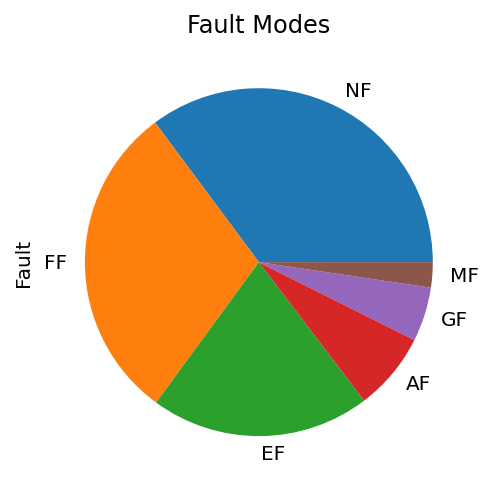

In [44]:
# Imbalanced fault modes
train_df.Fault.value_counts().plot.pie(title='Fault Modes')

In [47]:
X = train_df.iloc[:,:-1]
y = train_df.iloc[:,-1]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Make pipeline of SMOTE, scaling, and classifier
pipe = make_pipeline(SMOTE(), StandardScaler(), LGBMClassifier(random_state=42))

# Define multiple scoring metrics
scoring = {
    'acc': 'accuracy',
    'prec_macro': 'precision_macro',
    'rec_macro': 'recall_macro',
    'f1_macro': 'f1_macro'
}

# Stratified K-Fold 
stratkfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Return a dictionary of all scorings
cv_scores = cross_validate(pipe, X_train, y_train, cv=stratkfold, scoring=scoring)

In [53]:
type(X_test)

pandas.core.frame.DataFrame

In [54]:
X_test.to_csv('C:/Users/purva/OneDrive/Desktop/Project/X_test.csv', index=False)

In [48]:
# Print scoring results from dictionary
for metric_name, metric_value in cv_scores.items():
    mean = np.mean(metric_value)
    print(f'{metric_name}: {np.round(metric_value, 4)}, Mean: {np.round(mean, 4)}')

fit_time: [0.6158 0.7647 0.6656 0.7522 0.7281], Mean: 0.7053
score_time: [0.009  0.013  0.012  0.01   0.0109], Mean: 0.011
test_acc: [0.6917 0.7333 0.7143 0.7143 0.7311], Mean: 0.7169
test_prec_macro: [0.5866 0.6591 0.6927 0.6391 0.7106], Mean: 0.6576
test_rec_macro: [0.6079 0.6843 0.6634 0.5965 0.714 ], Mean: 0.6532
test_f1_macro: [0.5921 0.6707 0.6765 0.6103 0.7082], Mean: 0.6516


In [49]:
# Fit pipeline to train set
pipe.fit(X_train, y_train)

# Predict on test set
y_pred = pipe.predict(X_test)

In [52]:
import pickle
filename = './finalized_model.sav'
pickle.dump(pipe, open(filename, 'wb'))

In [74]:
y_pred

array(['AF', 'EF', 'NF', 'NF', 'FF', 'GF', 'NF', 'NF', 'AF', 'FF', 'FF',
       'EF', 'FF', 'MF', 'MF', 'EF', 'EF', 'EF', 'EF', 'GF', 'NF', 'EF',
       'NF', 'FF', 'FF', 'FF', 'FF', 'FF', 'AF', 'EF', 'EF', 'FF', 'EF',
       'FF', 'FF', 'FF', 'NF', 'FF', 'NF', 'FF', 'NF', 'NF', 'EF', 'NF',
       'MF', 'NF', 'NF', 'GF', 'FF', 'EF', 'EF', 'FF', 'NF', 'FF', 'EF',
       'EF', 'EF', 'NF', 'NF', 'FF', 'NF', 'EF', 'NF', 'EF', 'FF', 'NF',
       'AF', 'FF', 'GF', 'NF', 'NF', 'FF', 'NF', 'FF', 'NF', 'NF', 'EF',
       'AF', 'AF', 'NF', 'FF', 'NF', 'GF', 'FF', 'FF', 'FF', 'EF', 'FF',
       'FF', 'FF', 'EF', 'NF', 'EF', 'EF', 'NF', 'NF', 'AF', 'AF', 'FF',
       'NF', 'NF', 'FF', 'FF', 'EF', 'EF', 'NF', 'FF', 'NF', 'NF', 'NF',
       'FF', 'GF', 'FF', 'NF', 'NF', 'FF', 'AF', 'EF', 'EF', 'EF', 'EF',
       'EF', 'EF', 'FF', 'EF', 'EF', 'AF', 'NF', 'AF', 'EF', 'AF', 'NF',
       'NF', 'FF', 'FF', 'FF', 'FF', 'GF', 'NF', 'NF', 'EF', 'FF', 'EF',
       'NF', 'AF', 'NF', 'NF', 'FF', 'FF', 'GF', 'A

C:\Users\purva\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


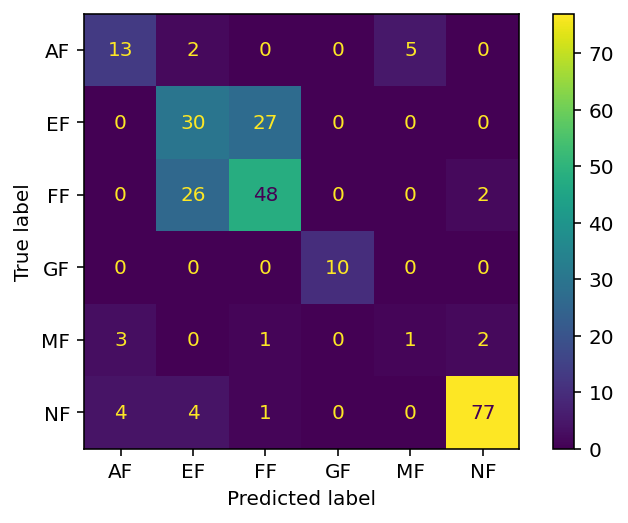

In [41]:
# Confusion matrix of test set
plot_confusion_matrix(pipe, X_test, y_test, values_format='.5g') 
plt.show()

In [42]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          AF       0.65      0.65      0.65        20
          EF       0.48      0.53      0.50        57
          FF       0.62      0.63      0.63        76
          GF       1.00      1.00      1.00        10
          MF       0.17      0.14      0.15         7
          NF       0.95      0.90      0.92        86

    accuracy                           0.70       256
   macro avg       0.65      0.64      0.64       256
weighted avg       0.71      0.70      0.70       256



In [30]:
# Define parameter search grid
param_grid = {'lgbmclassifier__n_estimators': [6, 8, 16, 24], 
              'lgbmclassifier__num_leaves': [4, 6, 8],
              'lgbmclassifier__reg_alpha' : [1, 1.5],
              'lgbmclassifier__reg_lambda': [1, 1.5],
              'lgbmclassifier__boosting_type': ['gbdt'] # Gradient Boosting Decision Tree
             }

# Grid search CV
grid = GridSearchCV(pipe, param_grid, verbose=1, cv=stratkfold, n_jobs=-1, scoring='f1_macro')

# Fit grid on train set
grid.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('smote', SMOTE()),
                                       ('standardscaler', StandardScaler()),
                                       ('lgbmclassifier',
                                        LGBMClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'lgbmclassifier__boosting_type': ['gbdt'],
                         'lgbmclassifier__n_estimators': [6, 8, 16, 24],
                         'lgbmclassifier__num_leaves': [4, 6, 8],
                         'lgbmclassifier__reg_alpha': [1, 1.5],
                         'lgbmclassifier__reg_lambda': [1, 1.5]},
             scoring='f1_macro', verbose=1)

In [31]:
# Best model from tuning
print(grid.best_params_)
print(f'Average of Macro F1: {grid.best_score_}')

{'lgbmclassifier__boosting_type': 'gbdt', 'lgbmclassifier__n_estimators': 24, 'lgbmclassifier__num_leaves': 4, 'lgbmclassifier__reg_alpha': 1, 'lgbmclassifier__reg_lambda': 1}
Average of Macro F1: 0.6943619367545145


C:\Users\purva\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


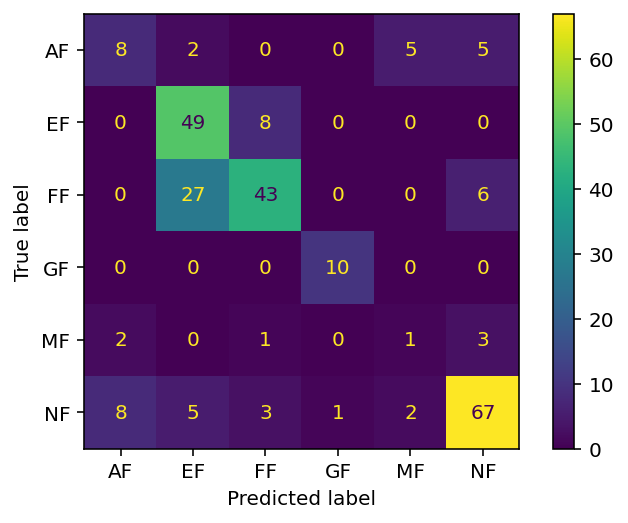

In [32]:
# Confusion matrix of test set
plot_confusion_matrix(grid, X_test, y_test, values_format='.5g') 
plt.show()

In [33]:
# Classification report
y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          AF       0.44      0.40      0.42        20
          EF       0.59      0.86      0.70        57
          FF       0.78      0.57      0.66        76
          GF       0.91      1.00      0.95        10
          MF       0.12      0.14      0.13         7
          NF       0.83      0.78      0.80        86

    accuracy                           0.70       256
   macro avg       0.61      0.62      0.61       256
weighted avg       0.72      0.70      0.69       256

